In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# !unzip -uq "/content/drive/MyDrive/Data/Data.zip"

In [65]:
#reading the text data 
import pandas as pd
caption_file = 'captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(10)

There are 40455 image to captions


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

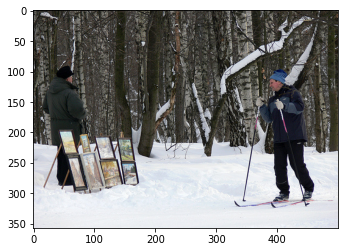

Caption: A man skis past another man displaying paintings in the snow .
Caption: A person wearing skis looking at framed pictures set up in the snow .
Caption: A skier looks at framed pictures in the snow next to trees .
Caption: Man on skis looking at artwork for sale in the snow
Caption: A collage of one person climbing a cliff .


In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 56

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
image_path = "Flickr8k_Dataset"
image_name = df.iloc[data_idx,0]
image = mpimg.imread(image_path + "/" + image_name)
plt.imshow(image)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])


# Custom dataset with Vocabulary

<p>Writing the custom torch dataset class so, that we can abastract out the dataloading steps during the training and validation process</p>
<p>Here, dataloader is created which gives the batch of image and its captions with following processing done:</p>

<li>caption word tokenized to unique numbers</li>
<li>vocab instance created to store all the relivent words in the datasets</li>
<li>each batch, caption padded to have same sequence length</li>
<li>image resized to the desired size and converted into captions</li>

<br><p>In this way the dataprocessing is done, and the dataloader is ready to be used with <b>Pytorch</b></p>

In [67]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

en_core_web is a pre-trained, small-sized language model provided by SpaCy for English language processing.

In [68]:
#using spacy for the better text tokenization 
# !python -m spacy download en_core_web_sm
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [69]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [70]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [71]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [72]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

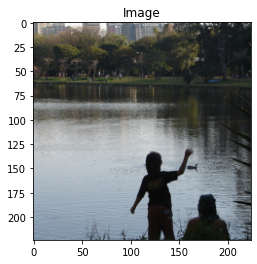

Token: tensor([  1,   4,  28,  16,   4,  80,  34,  19, 766, 163,   8,   4, 250, 215,
          5,   2])
Sentence:
['<SOS>', 'a', 'child', 'and', 'a', 'woman', 'are', 'at', 'waters', 'edge', 'in', 'a', 'big', 'city', '.', '<EOS>']


In [73]:
#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#testing the dataset class
dataset =  FlickrDataset(
    root_dir = "Flickr8k_Dataset",
    captions_file = "captions.txt",
    transform=transforms
)



img, caps = dataset[80]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [74]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [75]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

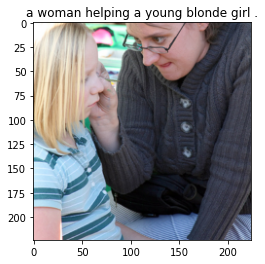

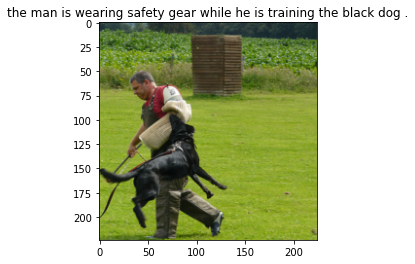

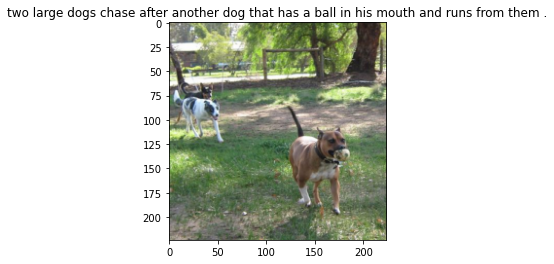

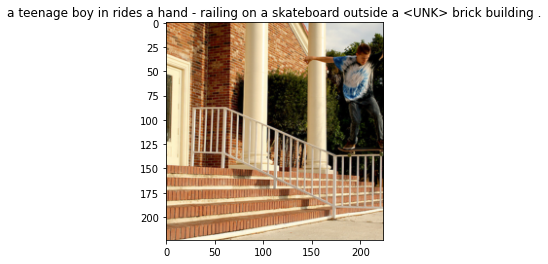

In [76]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()
    

# Attention Model configuration

The model consists of three modules: EncoderCNN, Attention, and DecoderRNN.

* EncoderCNN is a pre-trained ResNet50 model that extracts feature maps from input images.
* Attention is a module that allows the DecoderRNN to pay attention to certain features in the input. It generates an alignment score between the feature map representation and the previous decoder hidden state, which is used to calculate the context vector.
* DecoderRNN generates captions given the feature map representation and the previous word prediction. It uses the attention module to generate the context vector and passes it through an LSTM cell to generate the next hidden state. The output of the LSTM cell is passed through a linear layer to generate a one-hot vector of the predicted word.

In [77]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [79]:
# feature map representation from ResNet model will be used as input to our Attention model
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2] # everythin except last Conv block
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [80]:
#Bahdanau Attention - allows our Decoder to pay attention to certain features (important parts)
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        # we pass encoder/decoder hidden states to weights layer
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        # generate alignment scores
        self.A = nn.Linear(attention_dim,1)
        
    # as input we accept feature map representation  and prev decoder hidden state  
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        # adding one mode dimension for combined states
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        # conversion to probabilities using softmax
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        # generating the context vector
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        


In [81]:
# Attention Decoder module to generate captions
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        # generate embeddings for words
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        # features representation
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        # linear layer that outputs one-hot vector of predicted word
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    # inputs are feature representation and captions (vectors)    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        # predicted captions in form of one-hot vectors
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
        
        # feed in the input for each time instance along with context vectors
        for s in range(seq_length):
            # first, pass the features and decoder hidden state
            alpha,context = self.attention(features, h)
            
            # lstm input are embeddings repr words and context vectors
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            
            # hidden state for next time instance
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through dropout layer
            output = self.fcn(self.drop(h))
            
            # get the prediction and weights
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=50,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        # store the weights
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        # captions generated 
        captions = []
        
        for i in range(max_len):
            # take encoder output and compute the current attention
            alpha,context = self.attention(features, h)
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            # conatenation of current state embeddings and context vectors
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    # features from encoder CNN 
    def init_hidden_state(self, encoder_out):
        batch_size = encoder_out.size(0)
        h = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        c = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        return h, c

In [82]:
# Seq2Seq model to generate image captions

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        # encoder doesn't need any params to specify
        self.encoder = EncoderCNN()
        # decoder params need to be specified
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
    
    def forward(self, images, captions):
        # pass the images through encoder to ger feature representations
        features = self.encoder(images)
        # features and captions are passed to decoder
        outputs = self.decoder(features, captions)
        return outputs


# Setting Hypperparameter and model initialization

In [83]:
# Hyperparams to tweak

embed_size=500
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [84]:
# Seq2Seq model initialization

model = EncoderDecoder(
    embed_size=500,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [85]:
# helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

# Training Job from above configs

**Watch as with every epoch the generated text becomes more and more meaningful !**

Epoch: 1 Batch: 1000 loss: 3.09424
Epoch: 1 Batch: 2000 loss: 3.30543
Epoch: 1 Batch: 3000 loss: 3.45678
Epoch: 1 Batch: 4000 loss: 3.13777
Epoch: 1 Batch: 5000 loss: 3.35742
Epoch: 1 Batch: 6000 loss: 2.93664
Epoch: 1 Batch: 7000 loss: 3.14616
Epoch: 1 Batch: 8000 loss: 3.51865
Epoch: 1 Batch: 9000 loss: 2.81572
Epoch: 1 Batch: 10000 loss: 2.68126


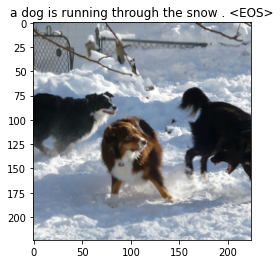

Epoch: 2 Batch: 1000 loss: 3.33911
Epoch: 2 Batch: 2000 loss: 2.34674
Epoch: 2 Batch: 3000 loss: 2.20511
Epoch: 2 Batch: 4000 loss: 3.10097
Epoch: 2 Batch: 5000 loss: 2.72635
Epoch: 2 Batch: 6000 loss: 2.82964
Epoch: 2 Batch: 7000 loss: 2.80017
Epoch: 2 Batch: 8000 loss: 2.18853
Epoch: 2 Batch: 9000 loss: 2.50563
Epoch: 2 Batch: 10000 loss: 2.08893


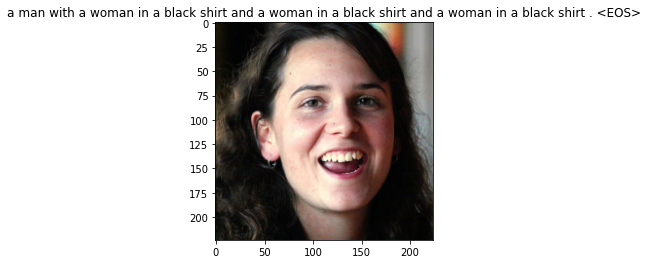

Epoch: 3 Batch: 1000 loss: 2.63126
Epoch: 3 Batch: 2000 loss: 2.11304
Epoch: 3 Batch: 3000 loss: 2.79632
Epoch: 3 Batch: 4000 loss: 2.66441
Epoch: 3 Batch: 5000 loss: 2.71886
Epoch: 3 Batch: 6000 loss: 3.05579
Epoch: 3 Batch: 7000 loss: 2.36410
Epoch: 3 Batch: 8000 loss: 2.08318
Epoch: 3 Batch: 9000 loss: 2.51450
Epoch: 3 Batch: 10000 loss: 2.61259


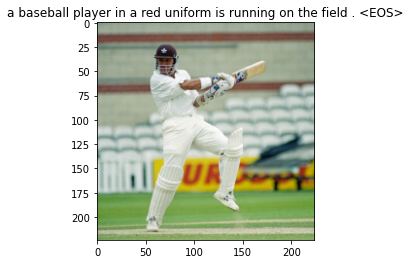

Epoch: 4 Batch: 1000 loss: 2.59398
Epoch: 4 Batch: 2000 loss: 2.26869
Epoch: 4 Batch: 3000 loss: 2.22606
Epoch: 4 Batch: 4000 loss: 2.88290
Epoch: 4 Batch: 5000 loss: 2.17704
Epoch: 4 Batch: 6000 loss: 2.67521
Epoch: 4 Batch: 7000 loss: 3.21523
Epoch: 4 Batch: 8000 loss: 2.61748
Epoch: 4 Batch: 9000 loss: 2.69488
Epoch: 4 Batch: 10000 loss: 2.49043


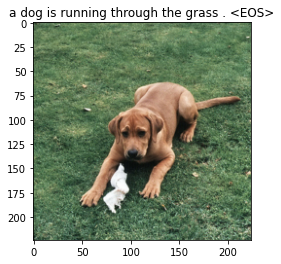

Epoch: 5 Batch: 1000 loss: 1.94668
Epoch: 5 Batch: 2000 loss: 2.68131
Epoch: 5 Batch: 3000 loss: 2.46988
Epoch: 5 Batch: 4000 loss: 2.51639
Epoch: 5 Batch: 5000 loss: 2.43548
Epoch: 5 Batch: 6000 loss: 2.36920
Epoch: 5 Batch: 7000 loss: 2.40972
Epoch: 5 Batch: 8000 loss: 2.28456
Epoch: 5 Batch: 9000 loss: 2.49515
Epoch: 5 Batch: 10000 loss: 2.82988


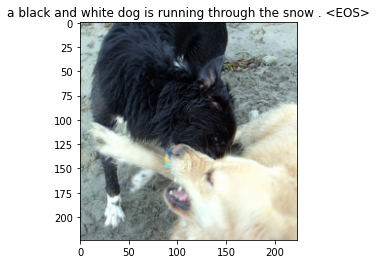

Epoch: 6 Batch: 1000 loss: 2.19375
Epoch: 6 Batch: 2000 loss: 2.36335
Epoch: 6 Batch: 3000 loss: 2.27565
Epoch: 6 Batch: 4000 loss: 2.42708
Epoch: 6 Batch: 5000 loss: 1.87933
Epoch: 6 Batch: 6000 loss: 2.61757
Epoch: 6 Batch: 7000 loss: 1.97621
Epoch: 6 Batch: 8000 loss: 2.66461
Epoch: 6 Batch: 9000 loss: 2.25218
Epoch: 6 Batch: 10000 loss: 2.31080


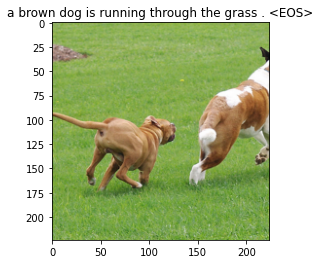

Epoch: 7 Batch: 1000 loss: 2.12662
Epoch: 7 Batch: 2000 loss: 1.92154
Epoch: 7 Batch: 3000 loss: 2.58392
Epoch: 7 Batch: 4000 loss: 2.34699
Epoch: 7 Batch: 5000 loss: 1.98254
Epoch: 7 Batch: 6000 loss: 1.81942
Epoch: 7 Batch: 7000 loss: 1.81771
Epoch: 7 Batch: 8000 loss: 2.44212
Epoch: 7 Batch: 9000 loss: 2.69419
Epoch: 7 Batch: 10000 loss: 2.35226


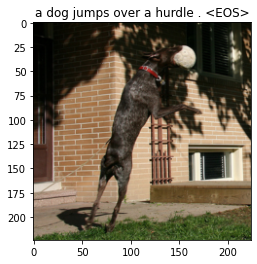

Epoch: 8 Batch: 1000 loss: 2.18189
Epoch: 8 Batch: 2000 loss: 2.24480
Epoch: 8 Batch: 3000 loss: 1.93262
Epoch: 8 Batch: 4000 loss: 2.50670
Epoch: 8 Batch: 5000 loss: 2.59194
Epoch: 8 Batch: 6000 loss: 2.73643
Epoch: 8 Batch: 7000 loss: 2.22665
Epoch: 8 Batch: 8000 loss: 2.16821
Epoch: 8 Batch: 9000 loss: 2.07798
Epoch: 8 Batch: 10000 loss: 2.42818


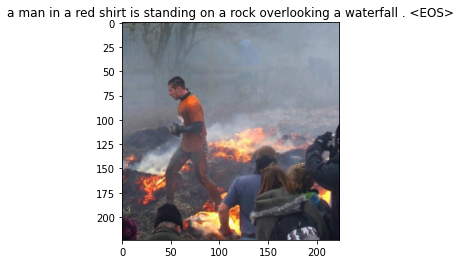

Epoch: 9 Batch: 1000 loss: 1.86135
Epoch: 9 Batch: 2000 loss: 2.15401
Epoch: 9 Batch: 3000 loss: 2.51425
Epoch: 9 Batch: 4000 loss: 2.99571
Epoch: 9 Batch: 5000 loss: 2.40981
Epoch: 9 Batch: 6000 loss: 2.15421
Epoch: 9 Batch: 7000 loss: 1.74640
Epoch: 9 Batch: 8000 loss: 1.88619
Epoch: 9 Batch: 9000 loss: 2.65780
Epoch: 9 Batch: 10000 loss: 2.46783


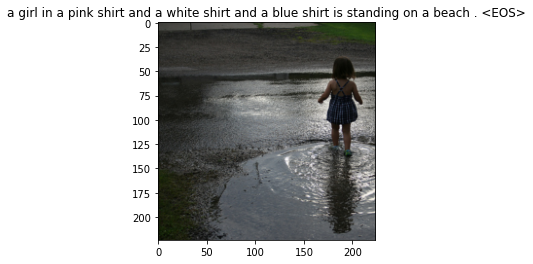

Epoch: 10 Batch: 1000 loss: 2.67603
Epoch: 10 Batch: 2000 loss: 2.39395
Epoch: 10 Batch: 3000 loss: 2.59891
Epoch: 10 Batch: 4000 loss: 1.82129
Epoch: 10 Batch: 5000 loss: 1.44800
Epoch: 10 Batch: 6000 loss: 2.09450
Epoch: 10 Batch: 7000 loss: 2.19992
Epoch: 10 Batch: 8000 loss: 2.28743
Epoch: 10 Batch: 9000 loss: 2.61249
Epoch: 10 Batch: 10000 loss: 2.91202


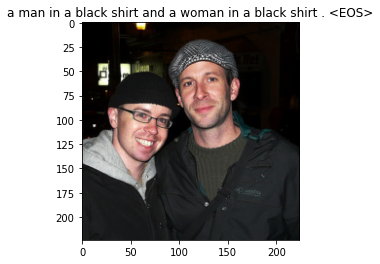

Epoch: 11 Batch: 1000 loss: 2.50505
Epoch: 11 Batch: 2000 loss: 2.33620
Epoch: 11 Batch: 3000 loss: 1.74638
Epoch: 11 Batch: 4000 loss: 2.51697
Epoch: 11 Batch: 5000 loss: 2.35098
Epoch: 11 Batch: 6000 loss: 2.79729
Epoch: 11 Batch: 7000 loss: 2.44949
Epoch: 11 Batch: 8000 loss: 2.28599
Epoch: 11 Batch: 9000 loss: 1.98908
Epoch: 11 Batch: 10000 loss: 2.34305


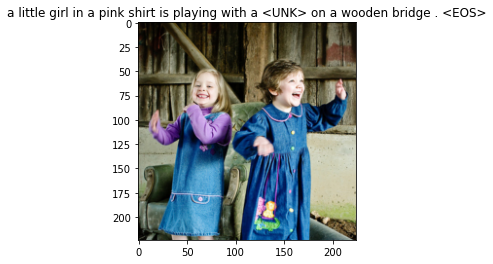

Epoch: 12 Batch: 1000 loss: 1.92636
Epoch: 12 Batch: 2000 loss: 2.00435
Epoch: 12 Batch: 3000 loss: 2.45860
Epoch: 12 Batch: 4000 loss: 1.97886
Epoch: 12 Batch: 5000 loss: 1.81859
Epoch: 12 Batch: 6000 loss: 2.09092
Epoch: 12 Batch: 7000 loss: 2.34766
Epoch: 12 Batch: 8000 loss: 2.48665
Epoch: 12 Batch: 9000 loss: 1.86503
Epoch: 12 Batch: 10000 loss: 2.29430


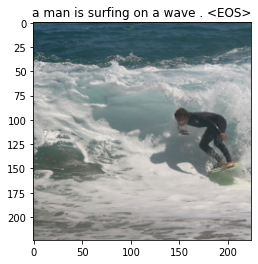

Epoch: 13 Batch: 1000 loss: 2.37039
Epoch: 13 Batch: 2000 loss: 2.70637
Epoch: 13 Batch: 3000 loss: 2.10344
Epoch: 13 Batch: 4000 loss: 2.66125
Epoch: 13 Batch: 5000 loss: 1.84501
Epoch: 13 Batch: 6000 loss: 2.38779
Epoch: 13 Batch: 7000 loss: 1.64513
Epoch: 13 Batch: 8000 loss: 1.76232
Epoch: 13 Batch: 9000 loss: 2.22640
Epoch: 13 Batch: 10000 loss: 2.65436


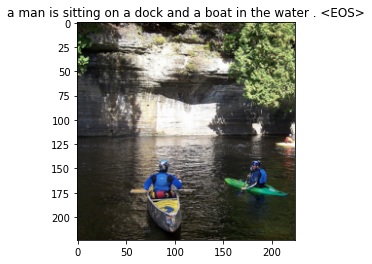

Epoch: 14 Batch: 1000 loss: 2.24839
Epoch: 14 Batch: 2000 loss: 2.27926
Epoch: 14 Batch: 3000 loss: 2.09003
Epoch: 14 Batch: 4000 loss: 1.82293
Epoch: 14 Batch: 5000 loss: 2.23266
Epoch: 14 Batch: 6000 loss: 1.97700
Epoch: 14 Batch: 7000 loss: 2.43542
Epoch: 14 Batch: 8000 loss: 2.11061
Epoch: 14 Batch: 9000 loss: 2.50099
Epoch: 14 Batch: 10000 loss: 2.43295


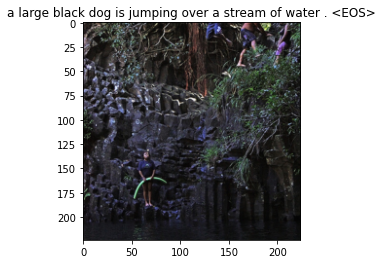

Epoch: 15 Batch: 1000 loss: 1.81595
Epoch: 15 Batch: 2000 loss: 2.59226
Epoch: 15 Batch: 3000 loss: 1.67888
Epoch: 15 Batch: 4000 loss: 1.60469
Epoch: 15 Batch: 5000 loss: 2.01722
Epoch: 15 Batch: 6000 loss: 2.42702
Epoch: 15 Batch: 7000 loss: 2.63174
Epoch: 15 Batch: 8000 loss: 2.24774
Epoch: 15 Batch: 9000 loss: 2.18531
Epoch: 15 Batch: 10000 loss: 2.19378


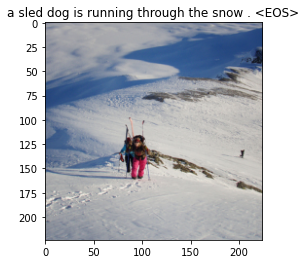

Epoch: 16 Batch: 1000 loss: 2.03105
Epoch: 16 Batch: 2000 loss: 1.75207
Epoch: 16 Batch: 3000 loss: 1.92404
Epoch: 16 Batch: 4000 loss: 2.03258
Epoch: 16 Batch: 5000 loss: 1.95757
Epoch: 16 Batch: 6000 loss: 1.93799
Epoch: 16 Batch: 7000 loss: 2.00854
Epoch: 16 Batch: 8000 loss: 2.33266
Epoch: 16 Batch: 9000 loss: 2.49982
Epoch: 16 Batch: 10000 loss: 2.41001


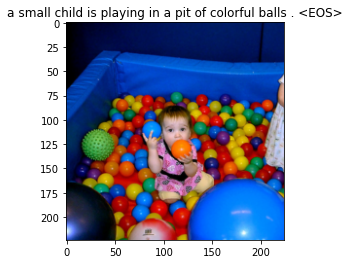

Epoch: 17 Batch: 1000 loss: 1.87663
Epoch: 17 Batch: 2000 loss: 1.87029
Epoch: 17 Batch: 3000 loss: 1.95217
Epoch: 17 Batch: 4000 loss: 1.67411
Epoch: 17 Batch: 5000 loss: 1.79360
Epoch: 17 Batch: 6000 loss: 2.17908
Epoch: 17 Batch: 7000 loss: 2.16715
Epoch: 17 Batch: 8000 loss: 1.58152
Epoch: 17 Batch: 9000 loss: 2.18689
Epoch: 17 Batch: 10000 loss: 1.98104


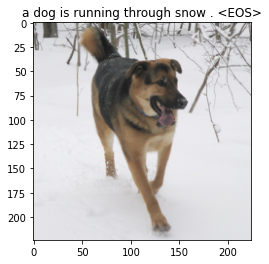

Epoch: 18 Batch: 1000 loss: 1.79980
Epoch: 18 Batch: 2000 loss: 1.60881
Epoch: 18 Batch: 3000 loss: 1.95071
Epoch: 18 Batch: 4000 loss: 1.75889
Epoch: 18 Batch: 5000 loss: 2.05260
Epoch: 18 Batch: 6000 loss: 2.27455
Epoch: 18 Batch: 7000 loss: 2.83653
Epoch: 18 Batch: 8000 loss: 2.06389
Epoch: 18 Batch: 9000 loss: 1.46887
Epoch: 18 Batch: 10000 loss: 1.91942


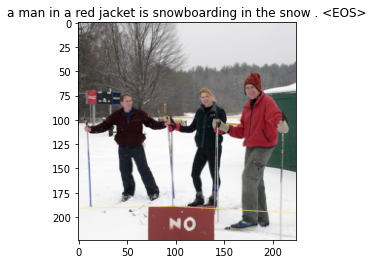

Epoch: 19 Batch: 1000 loss: 1.73454
Epoch: 19 Batch: 2000 loss: 2.25670
Epoch: 19 Batch: 3000 loss: 2.26282
Epoch: 19 Batch: 4000 loss: 2.20923
Epoch: 19 Batch: 5000 loss: 1.80866
Epoch: 19 Batch: 6000 loss: 2.47360
Epoch: 19 Batch: 7000 loss: 2.20122
Epoch: 19 Batch: 8000 loss: 2.54119
Epoch: 19 Batch: 9000 loss: 2.09950
Epoch: 19 Batch: 10000 loss: 2.33737


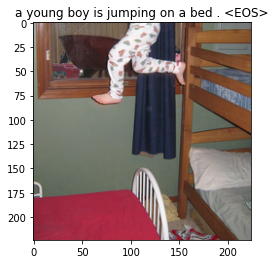

Epoch: 20 Batch: 1000 loss: 1.92838
Epoch: 20 Batch: 2000 loss: 1.76077
Epoch: 20 Batch: 3000 loss: 1.68605
Epoch: 20 Batch: 4000 loss: 1.75596
Epoch: 20 Batch: 5000 loss: 2.30642
Epoch: 20 Batch: 6000 loss: 1.56603
Epoch: 20 Batch: 7000 loss: 2.55978
Epoch: 20 Batch: 8000 loss: 2.02684
Epoch: 20 Batch: 9000 loss: 1.75671
Epoch: 20 Batch: 10000 loss: 1.80614


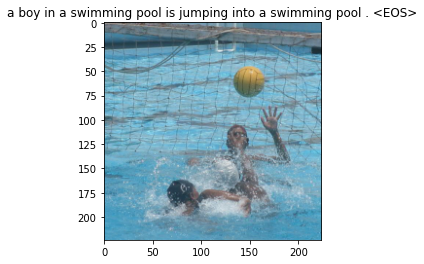

Epoch: 21 Batch: 1000 loss: 2.17594
Epoch: 21 Batch: 2000 loss: 2.63613
Epoch: 21 Batch: 3000 loss: 2.11889
Epoch: 21 Batch: 4000 loss: 1.83740
Epoch: 21 Batch: 5000 loss: 2.28660
Epoch: 21 Batch: 6000 loss: 2.68385
Epoch: 21 Batch: 7000 loss: 1.91716
Epoch: 21 Batch: 8000 loss: 2.04829
Epoch: 21 Batch: 9000 loss: 2.24215
Epoch: 21 Batch: 10000 loss: 2.40636


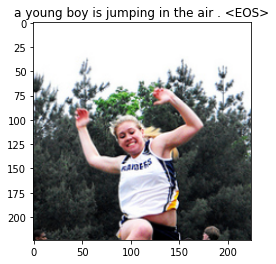

Epoch: 22 Batch: 1000 loss: 1.80056
Epoch: 22 Batch: 2000 loss: 1.94919
Epoch: 22 Batch: 3000 loss: 2.26415
Epoch: 22 Batch: 4000 loss: 2.53575
Epoch: 22 Batch: 5000 loss: 1.68663
Epoch: 22 Batch: 6000 loss: 1.92213
Epoch: 22 Batch: 7000 loss: 1.83746
Epoch: 22 Batch: 8000 loss: 1.70528
Epoch: 22 Batch: 9000 loss: 2.10684
Epoch: 22 Batch: 10000 loss: 2.08796


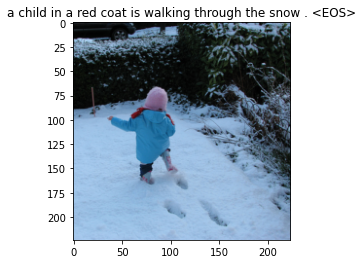

Epoch: 23 Batch: 1000 loss: 1.84094
Epoch: 23 Batch: 2000 loss: 2.32684
Epoch: 23 Batch: 3000 loss: 2.24448
Epoch: 23 Batch: 4000 loss: 1.48447
Epoch: 23 Batch: 5000 loss: 1.79441
Epoch: 23 Batch: 6000 loss: 2.40729
Epoch: 23 Batch: 7000 loss: 1.91772
Epoch: 23 Batch: 8000 loss: 1.76164
Epoch: 23 Batch: 9000 loss: 1.60431
Epoch: 23 Batch: 10000 loss: 1.83369


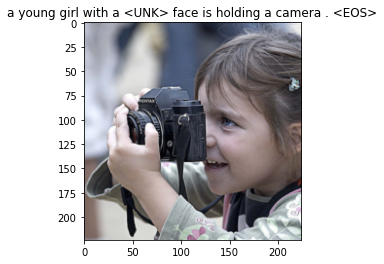

Epoch: 24 Batch: 1000 loss: 1.80754
Epoch: 24 Batch: 2000 loss: 2.33836
Epoch: 24 Batch: 3000 loss: 1.82287
Epoch: 24 Batch: 4000 loss: 2.12608
Epoch: 24 Batch: 5000 loss: 1.87799
Epoch: 24 Batch: 6000 loss: 2.11701
Epoch: 24 Batch: 7000 loss: 2.19707
Epoch: 24 Batch: 8000 loss: 1.90300
Epoch: 24 Batch: 9000 loss: 2.42266
Epoch: 24 Batch: 10000 loss: 2.50663


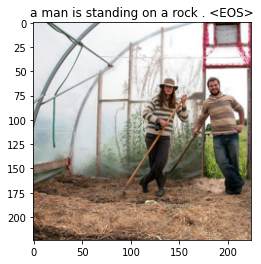

Epoch: 25 Batch: 1000 loss: 2.26955
Epoch: 25 Batch: 2000 loss: 2.53575
Epoch: 25 Batch: 3000 loss: 1.80951
Epoch: 25 Batch: 4000 loss: 2.66980
Epoch: 25 Batch: 5000 loss: 1.21634
Epoch: 25 Batch: 6000 loss: 2.17553
Epoch: 25 Batch: 7000 loss: 1.93262
Epoch: 25 Batch: 8000 loss: 2.51560
Epoch: 25 Batch: 9000 loss: 1.72484
Epoch: 25 Batch: 10000 loss: 1.72049


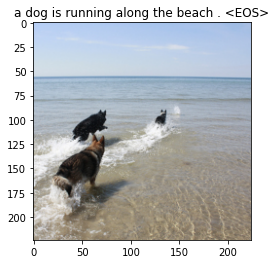

In [87]:
num_epochs = 25
print_every = 1000

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} Batch: {} loss: {:.5f}".format(epoch, idx+1, loss.item()))
        
    #generate the caption and display it
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        img,_ = next(dataiter)
        features = model.encoder(img[0:1].to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0],title=caption)

    model.train()

    #save the latest model after every epoch
    save_model(model,epoch)

In [ ]:
# Save the model
save_model(model,num_epochs)

# Visualizing the model'a attention

In [93]:
# generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

In [94]:
# Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

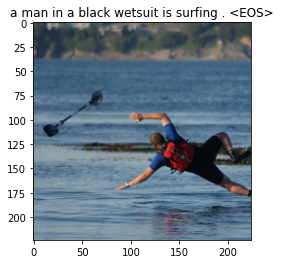

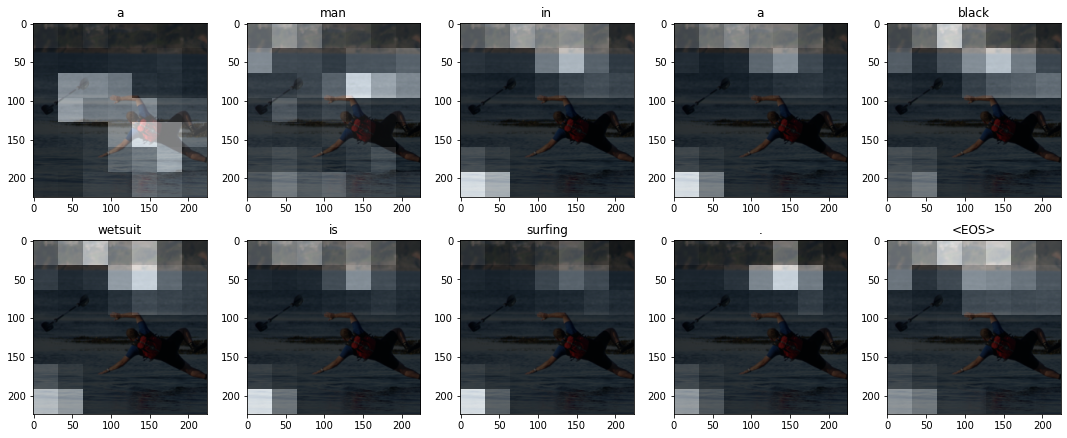

In [95]:
# show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

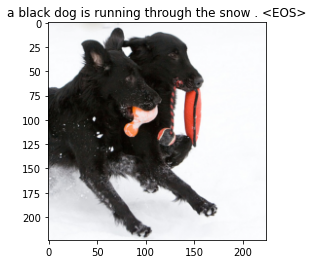

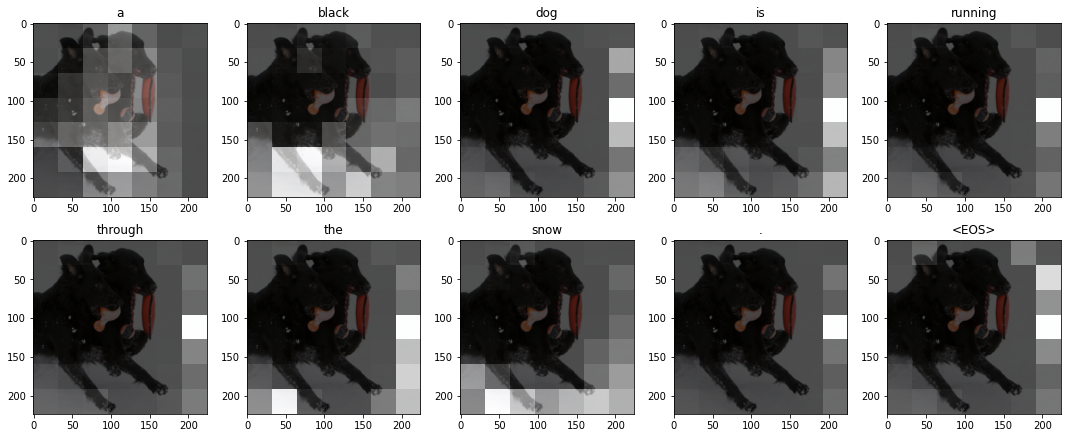

In [96]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

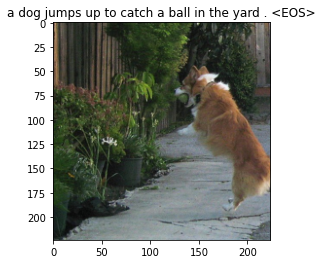

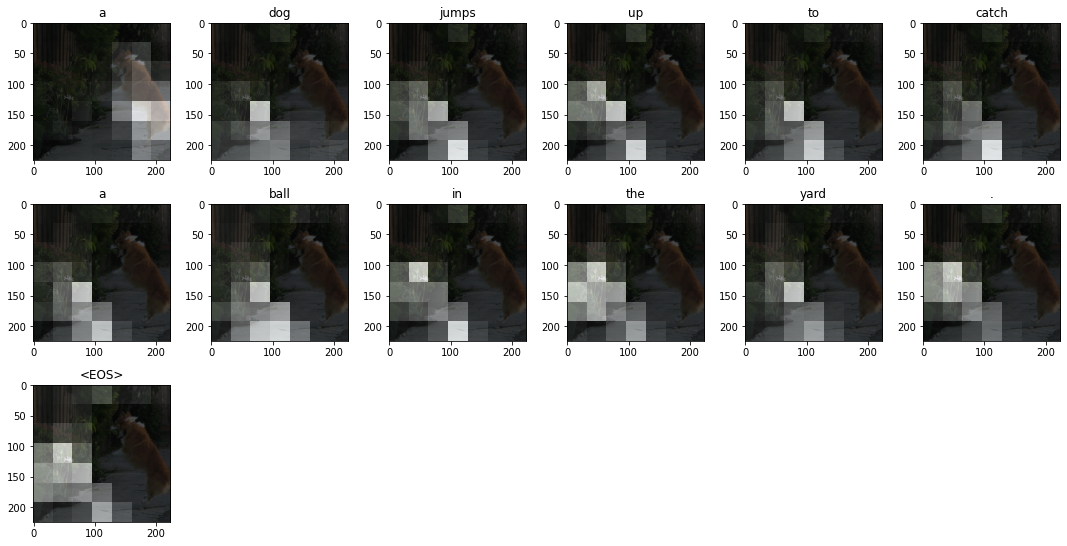

In [97]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

# Evalute model with BLEU score

In [1]:

from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        references, hypotheses = list(), list()
        for idx, (image, captions) in enumerate(iter(data_loader)):
            image,captions = image.to(device),captions.to(device)
            features = model.encoder(image)
            caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
            references.append([captions[0].tolist()])
            hypotheses.append(caps)
            if idx == 100:
                break
        bleu = corpus_bleu(references, hypotheses)
        print("BLEU score: {:.4f}".format(bleu))
        
evaluate_model(model, data_loader)



NameError: name 'model' is not defined